<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

# 🎓 ATLANTIS: Automated Language Analysis and Text Intelligence System

<span style="font-size: 20px; font-weight: bold;">Asignatura: Trabajo Fin de Grado - Grado Ingeniería Informática</span>

<span style="font-size: 14px; font-weight: bold;">Autora: Silvia Barrera Ibáñez</span>

**Fecha:** 25 de abril de 2025


**Objetivo del Notebook:**
Este notebook está diseñado para analizar textos transcritos a partir de reconocimiento de voz,
utilizando técnicas avanzadas de procesamiento de lenguaje natural para cumplir con criterios específicos.


# 🎓 ATLANTIS: Sistema de verificación de conceptos del evaluador tras lectura pública del opositor

Este cuaderno permite a los evaluadores:
- 🧠 Agregar/Subir conceptos clave (.txt)
- 🎙️ Subir un audio generado por el aspirante(.mp3, .wav...)
- 🛠️ Transcribir automáticamente
- 🔎 Verificar conceptos, extraer temas (LDA) y clústeres

⚠️ Ejecuta cada celda en orden

## ⚙️ Importación de librerías y configuración inicial

Este módulo configura el entorno necesario para el sistema de transcripción y análisis semántico. A continuación, **debes importar y preparar** los elementos necesarios para que la herramienta funcione.

> 💡 Esta celda **no ejecuta procesamiento aún**, pero **debe ejecutarse antes** que cualquier otra para asegurar que todas las funciones posteriores estén disponibles y libres de errores de entorno.

In [1]:
#Importacion de las librerías necesarias

import spacy 
import pandas as pd
import whisper
import json
import os
import re
import pandas as pd
from IPython.display import display, Markdown
import time
from spacy.matcher import PhraseMatcher 
from IPython.display import display, HTML, Javascript
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

## 🧰 Configuración de widgets e importación de conceptos por el evaluador

## 🧾 Interfaz interactiva para ingresar o importar elementos clave

Esta celda implementa un **gestor visual de elementos clave** (como conceptos importantes, temas a verificar, etc.) que luego serán utilizados en el análisis de transcripciones.

---

### 🧩 Funcionalidades principales

| Función                          | Descripción                                                                 |
|--------------------------------- |-----------------------------------------------------------------------------|
| ➕ Agregar                       | Añade un nuevo elemento a la lista manualmente.                             |
| ✏️ Editar                        | Permite modificar un elemento ya existente en la lista.                     |
| 🗑️ Eliminar                      | Quita el elemento seleccionado de la lista.                                 |
| 📂 Importar archivo (.txt/.json) | Carga elementos desde un archivo plano (`.txt`) o estructura JSON (`.json`).|
| ✅ Finalizar                     | Guarda la lista de elementos ingresados en un archivo `elementos.json`.     |

---

### 🚀 Flujo de uso sugerido

1. 📥 **Importa** elementos desde archivo o comienza desde cero.
2. ✍️ **Agrega manualmente** nuevos conceptos clave.
3. 🧹 **Edita o elimina** los elementos según necesidad.
4. 💾 **Haz clic en "Finalizar"** para guardar todo en `elementos.json`.
5. 📑 Estos datos estarán disponibles más adelante para tareas de verificación y análisis.

---

### 🖼️ Vista generada

La celda mostrará una caja interactiva similar a esta:

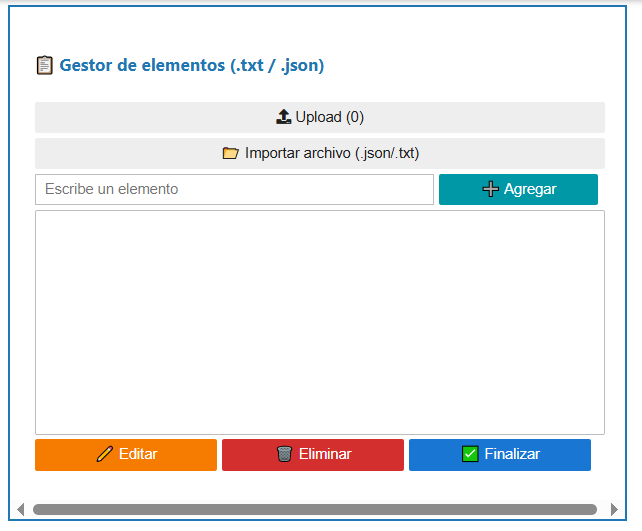

In [2]:
import tkinter as tk
from tkinter import filedialog, messagebox
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
import json
from io import BytesIO

def pedir_elementos_manual():
    lista_elementos = []

    entrada = widgets.Text(
        placeholder="Añade un elemento de forma manual",
        layout=widgets.Layout(width="70%")
    )

    boton_agregar = widgets.Button(
        description="➕ Agregar", 
        button_style="info", 
        layout=widgets.Layout(width="28%")
    )
    boton_eliminar = widgets.Button(
        description="🗑️ Eliminar", 
        button_style="danger", 
        layout=widgets.Layout(width="32%")
    )
    boton_editar = widgets.Button(
        description="✏️ Editar", 
        button_style="warning", 
        layout=widgets.Layout(width="32%")
    )
    boton_finalizar = widgets.Button(
        description="✅ Finalizar", 
        button_style="primary", 
        layout=widgets.Layout(width="32%")
    )

    boton_importar = widgets.Button(
        description="📂 Importar archivo (.json/.txt)", 
        button_style="", 
        layout=widgets.Layout(width="100%")
    )
    archivo_upload = widgets.FileUpload(
        accept=".json,.txt", 
        multiple=False, 
        layout=widgets.Layout(width="100%")
    )

    lista = widgets.Select(
        options=lista_elementos, 
        rows=8, 
        layout=widgets.Layout(width="100%", height="200px")
    )
    salida = widgets.Output()

    editando_idx = [None]

    def agregar_elemento(_):
        valor = entrada.value.strip()
        if not valor:
            return
        if editando_idx[0] is not None:
            lista_elementos[editando_idx[0]] = valor
            editando_idx[0] = None
        else:
            lista_elementos.append(valor)
        lista.options = lista_elementos
        entrada.value = ""

    def eliminar_elemento(_):
        seleccionado = lista.index
        if seleccionado is not None and 0 <= seleccionado < len(lista_elementos):
            del lista_elementos[seleccionado]
            lista.options = lista_elementos

    def editar_elemento(_):
        seleccionado = lista.index
        if seleccionado is not None and 0 <= seleccionado < len(lista_elementos):
            entrada.value = lista_elementos[seleccionado]
            editando_idx[0] = seleccionado

    def finalizar(_):
        global elementos_ingresados
        elementos_ingresados = lista_elementos.copy()
        with open("elementos.json", "w", encoding="utf-8") as f:
            json.dump(elementos_ingresados, f, ensure_ascii=False, indent=2)
        with salida:
            clear_output()
            print("✅ Conceptos clave guardados en 'elementos.json':")
            print(elementos_ingresados)

    def importar_desde_archivo(_):
        with salida:
            clear_output()
            if not archivo_upload.value:
                print("No se ha cargado ningún archivo.")
                return

            # Itera sobre los archivos cargados (solo se permite uno)
            for file_info in archivo_upload.value:
                # Obtiene el nombre del archivo desde 'metadata' o directamente desde 'name'
                if 'metadata' in file_info and 'name' in file_info['metadata']:
                    file_name = file_info['metadata']['name']
                else:
                    file_name = file_info.get('name', 'unknown')
                    
                print(f"Procesando archivo: {file_name}")
                try:
                    if file_name.endswith(".txt"):
                        contenido_bytes = file_info['content']
                        # Convierte memoryview a bytes, si es necesario
                        if isinstance(contenido_bytes, memoryview):
                            contenido_bytes = bytes(contenido_bytes)
                        try:
                            texto = contenido_bytes.decode("utf-8")
                        except UnicodeDecodeError:
                            print("❌ Error de decodificación. Intenta con otra codificación.")
                            return
                        print("Contenido leído del TXT:")
                        print(texto)
                        lineas = texto.splitlines()
                        lista_elementos.clear()
                        lista_elementos.extend(line.strip() for line in lineas if line.strip())
                        lista.options = lista_elementos
                        print(f"📥 Lista importada desde TXT: {lista_elementos}")
                    elif file_name.endswith(".json"):
                        contenido_bytes = file_info['content']
                        if isinstance(contenido_bytes, memoryview):
                            contenido_bytes = bytes(contenido_bytes)
                        texto = contenido_bytes.decode("utf-8")
                        print("Contenido leído del JSON:")
                        print(texto)
                        datos = json.loads(texto)
                        if isinstance(datos, list):
                            lista_elementos.clear()
                            lista_elementos.extend(str(d) for d in datos)
                            lista.options = lista_elementos
                            print(f"📥 Lista importada desde JSON: {lista_elementos}")
                        else:
                            print("⚠️ El JSON no es una lista válida.")
                    else:
                        print("⚠️ Tipo de archivo no soportado.")
                except Exception as e:
                    print(f"❌ Error al importar el archivo: {e}")

    boton_agregar.on_click(agregar_elemento)
    boton_eliminar.on_click(eliminar_elemento)
    boton_editar.on_click(editar_elemento)
    boton_finalizar.on_click(finalizar)
    boton_importar.on_click(importar_desde_archivo)

    entrada_y_agregar = widgets.HBox([entrada, boton_agregar])
    botones_accion = widgets.HBox([boton_editar, boton_eliminar, boton_finalizar])

    caja = widgets.VBox([
        widgets.HTML("<h3 style='color:#1f77b4;'>📋 Importar conceptos a evaluar (.txt / .json)</h3>"),
        archivo_upload,
        boton_importar,
        entrada_y_agregar,
        lista,
        botones_accion,
        salida
    ], layout=widgets.Layout(
        border="2px solid #1f77b4",
        padding="20px",
        width="50%",
        margin="0 auto",
        border_radius="10px",
        box_shadow="0 2px 8px rgba(31, 119, 180, 0.2)"
    ))

    display(caja)

In [4]:
pedir_elementos_manual()

### ✏️ Repasa los conceptos ingresados y comprueba que son correctos

In [5]:
from IPython.display import display, HTML

def mostrar_elementos_ingresados(elementos):
    html = f"""
    <div style="
        background-color: #f7fbff;
        padding: 15px;
        border-radius: 10px;
        border: 1px solid #90caf9;
        font-family: Arial, sans-serif;
        color: #0d47a1;
        margin-top: 10px;
        width: 420px;
        margin-left: auto;
        margin-right: auto;
        box-shadow: 0 2px 6px rgba(0,0,0,0.1);">
        
        <h3 style="margin-top: 0;">
            <span style="font-size: 20px;">📌</span> 
            <span style="color:#0d47a1;">Conceptos clave ingresados</span>
        </h3>
        
        <table style='width: 100%; border-collapse: collapse; font-size: 14px;'>
            <thead>
                <tr style='background-color: #e3f2fd; text-align: left;'>
                    <th style='padding: 6px 8px; border-bottom: 1px solid #bbdefb; width: 30px;'>ID</th>
                    <th style='padding: 6px 8px; border-bottom: 1px solid #bbdefb;'>Elemento</th>
                </tr>
            </thead>
            <tbody>
    """
    for idx, e in enumerate(elementos, 1):
        html += f"""
            <tr>
                <td style='padding: 6px 8px; border-bottom: 1px solid #e0e0e0;'>{idx}</td>
                <td style='padding: 6px 8px; border-bottom: 1px solid #e0e0e0;'>{e}</td>
            </tr>
        """
    html += "</tbody></table></div>"
    display(HTML(html))

# Mostrar caja con elementos:
mostrar_elementos_ingresados(elementos_ingresados)


ID,Elemento
1,Violencia de género
2,Medidas de protección integral
3,ISES 4/2019
4,VPR
5,Valoración Policial de riesgo
6,Niveles de riesgo
7,Orden de proteccion
8,Diligencias de incautación de armas
9,Domicilio de la víctima
10,Ley organica 1/2004


## 🧠 Carga del modelo SpaCy, transcripción, verificación y resumen de resultados

## 🧠 Núcleo del Sistema de Transcripción y Verificación

Esta celda contiene la **implementación principal del sistema inteligente** que procesa audios, transcribe su contenido, analiza su coherencia temática y verifica si incluye ciertos conceptos clave.

---

### ⚙️ Funcionalidades incluidas

| Módulo                        | Función                                                                 |
|------------------------------|------------------------------------------------------------------------|
| 🎙️ Transcripción automática   | Utiliza el modelo `whisper` para convertir audio en texto.            |
| 📚 Procesamiento de lenguaje | Usa `spaCy` para analizar el texto, lematizar y extraer temas.        |
| 🔎 Verificación semántica    | Evalúa si el texto contiene elementos clave previamente definidos.    |
| 📊 Métricas del sistema      | Calcula precisión, coherencia temática (LDA) y calidad de agrupación (silhouette). |
| 📂 Exportación               | Permite descargar el texto transcrito y un archivo `.txt` con metadatos. |

---

### 🔁 Flujo de ejecución

1. **Subida de archivo de audio** (`.mp3`, `.wav`, etc.).
2. El sistema muestra un **spinner** mientras procesa el audio.
3. Se realiza la **transcripción automática** del contenido.
4. El **evaluador podrá visualizar** los temas detectados y los grupos semánticos.
5. Se evalúa el texto con base en los elementos esperados.
6. Se generan **métricas detalladas** del rendimiento y cumplimiento.
7. Finalmente, el sistema permite **descargar** los resultados.

---

> 💡 Este bloque es el **motor central del sistema**, y debe ejecutarse antes de interactuar con los archivos de audio o generar informes.


# 📊 Resumen de Resultados del Análisis

En la celda siguiente se mostrará un recuadro informativo con las **métricas de rendimiento** obtenidas tras la transcripción y el análisis semántico del audio. Este informe visual incluye:

- **Conceptos clave encontrados:** Número de elementos de la lista que se detectaron en la transcripción.
- **Porcentaje de acierto:** Precisión de verificación expresada en porcentaje, reflejando la proporción de conceptos identificados respecto al total esperado.
- **Puntuación final del opositor:** Nota sobre 10 calculada a partir del porcentaje de acierto.

In [6]:
import spacy
import whisper
import time
import tempfile
import base64
import os
import json
import ipywidgets as widgets
from IPython.display import display, HTML, Markdown, clear_output
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.models import LdaModel
from collections import defaultdict
from datetime import datetime

# Cargar modelos
try:
    model = whisper.load_model("base")
    nlp = spacy.load("es_core_news_sm")
except Exception as e:
    display(HTML(f"<p style='color:#d32f2f;'>Error al cargar modelos: {e}</p>"))

# Variables globales
transcribed_text = None
metricas = {
    'precision_verificacion': 0.0,
    'coherencia_lda': 0.0,
    'silhouette_score': 0.0,
    'tiempo_transcripcion': 0.0
}

if os.path.exists("elementos.json"):
    with open("elementos.json", "r", encoding="utf-8") as f:
        elementos_ingresados = json.load(f)
else:
    elementos_ingresados = []  # O deja la lista vacía para que se llenen manualmente

# Funciones de apoyo
def mostrar_cabecera_personalizada():
    display(HTML("""
    <h2 style="color:#1f77b4;">
        <span style="font-size:20px; vertical-align:middle; margin-right:8px;">&#128266;</span>
        Sistema de Transcripción y Verificación
    </h2>
    <h3> Resumen de resultados</h3>
    """))

def mostrar_cajetin(mensaje, color_fondo="#ffffff", color_texto="#000000"):
    display(HTML(f"""
    <div style="
        border:1px solid #000;
        border-radius:5px;
        padding:10px;
        background-color:{color_fondo};
        color:{color_texto};
        font-family:Arial, sans-serif;
        font-size:16px;
        margin:10px 0;">
        {mensaje}
    </div>
    """))

def mostrar_spinner():
    display(HTML("""
    <div style="text-align:center; padding:20px;">
      <div style="
          border:6px solid #f3f3f3; 
          border-top:6px solid #1f77b4;
          border-radius:50%;
          width:40px;
          height:40px;
          animation: spin 1s linear infinite;
          margin:0 auto 15px;">
      </div>
      <p style="font-family:Arial, sans-serif; color:#666;">Procesando audio...</p>
    </div>
    <style>
    @keyframes spin {
      0% { transform: rotate(0deg); }
      100% { transform: rotate(360deg); }
    }
    </style>
    """))

def detectar_temas_lda(texto, num_topics=3):
    doc = nlp(texto)
    tokens = [[token.lemma_.lower() for token in sent if token.pos_ in {"NOUN", "VERB"}] for sent in doc.sents]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(tok) for tok in tokens]
    lda = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary)
    cm = CoherenceModel(model=lda, texts=tokens, coherence='c_v')
    metricas['coherencia_lda'] = cm.get_coherence()
    return [topic[1] for topic in lda.print_topics()]

def clustering_semantico(texto, num_clusters=3):
    doc = nlp(texto)
    embeddings = [token.vector for token in doc if token.has_vector]
    if len(embeddings) < num_clusters:
        metricas['silhouette_score'] = 0.0
        return [("Insuficientes datos", ["N/A"])]
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(embeddings)
    metricas['silhouette_score'] = silhouette_score(embeddings, kmeans.labels_)
    clusters = defaultdict(list)
    for token, label in zip(doc, kmeans.labels_):
        clusters[label].append(token.text)
    return clusters.items()

def verificar_contenido(texto, elementos, elementos_ingresados):
    # Asegurarnos de que texto sea siempre una cadena
    texto = texto or ""                 # si texto es None o "", se convierte en ""
    
    resultados = {}
    encontrados = 0
    for elem in elementos:
        estado = elem.lower() in texto.lower()
        tipo   = "Clave" if elem in elementos_ingresados else "Informativo"
        resultados[elem] = {"estado": estado, "tipo": tipo}
        if estado:
            encontrados += 1

    metricas['precision_verificacion'] = (
        encontrados / len(elementos)
        if elementos else 0.0
    )
    return resultados


def generar_resumen_metricas(resultados, texto):
    total = len(resultados)
    encontrados = sum(1 for v in resultados.values() if v["estado"])
    porcentaje = (encontrados / total)*100 if total > 0 else 0
    puntuacion = round(porcentaje / 10, 2)
    resumen = []
    resumen.append("=== TRANSCRIPCIÓN ===\n")
    resumen.append(texto)
    resumen.append("\n\n=== MÉTRICAS ===")
    resumen.append(f"\nPrecisión Verificación: {metricas['precision_verificacion']:.2%}")
    resumen.append(f"\nCoherencia LDA: {metricas['coherencia_lda']:.3f}")
    resumen.append(f"\nSilhouette Score: {metricas['silhouette_score']:.3f}")
    resumen.append(f"\nTiempo de Transcripción: {metricas['tiempo_transcripcion']:.2f} seg")
    resumen.append("\n\n=== VERIFICACIÓN DE CONCEPTOS ===")
    for elem, res in resultados.items():
        resumen.append(f"\n- {elem}: {'Encontrado' if res['estado'] else 'No encontrado'} ({res['tipo']})")
    return "\n".join(resumen)

def generar_enlace_descarga(informe, nombre_base, nombre_audio=None):
    try:
        from datetime import datetime

        # Obtener la fecha y hora actual con formato YYYYMMDD_HHMMSS y legible para encabezado
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        fecha_legible = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

        # Limpia el nombre del audio para usarlo en el nombre del archivo
        if nombre_audio:
            base = nombre_audio.rsplit('.', 1)[0]  # quitar extensión
            base = base.replace(" ", "_").replace("/", "_").replace("\\", "_")
            nombre_archivo = f"{base}_{timestamp}.txt"
        else:
            nombre_archivo = f"{nombre_base}_{timestamp}.txt"

        # Insertar fecha y nombre del audio en el encabezado del contenido
        encabezado = f"Informe generado el: {fecha_legible}\n"
        if nombre_audio:
            encabezado += f"Archivo de audio: {nombre_audio}\n"
            encabezado += "Este informe corresponde al análisis del archivo de audio cargado por el evaluador.\n"
        encabezado += "\n"
        informe_con_fecha = encabezado + informe

        # Codificar el contenido en base64
        contenido = base64.b64encode(informe_con_fecha.encode()).decode()

        # Crear el enlace de descarga con el nombre completo
        href = f'<a download="{nombre_archivo}" href="data:text/plain;base64,{contenido}" style="margin:10px 0;display:inline-block; font-family: Arial, sans-serif; font-size: 15px; color: #1565c0; text-decoration: none;">\n            📁 Descargar Informe generado el {timestamp}</a>'

        # Mostrar el enlace en la interfaz
        display(HTML(href))

    except Exception as e:
        mostrar_cajetin(f"\u274c Error al generar descarga: {str(e)}", "#ffebee", "#d32f2f")

# widget de subida de audio
upload_widget = widgets.FileUpload(
    accept=".mp3,.wav,.flac,.m4a",
    multiple=False,
    description="Subir audio"
)
# Mostrar la cabecera y el widget de subida
mostrar_cabecera_personalizada()
display(upload_widget)

# Creamos dos áreas de salida
spinner_output = widgets.Output()
resultado_output = widgets.Output()
display(spinner_output)
display(resultado_output)

import tempfile, time
from IPython.display import display, HTML, Markdown, clear_output

def procesar_audio(change):
    global transcribed_text
    spinner_output.clear_output(wait=True)
    resultado_output.clear_output(wait=True)
    
    # 1) Comprobar que hay un archivo subido
    if not upload_widget.value:
        with resultado_output:
            mostrar_cajetin("⚠️ No se ha subido ningún audio.", "#fff3e0", "#ef6c00")
        return

    try:
        # 2) Mostrar spinner
        with spinner_output:
            mostrar_spinner()
        
        # 3) Extraer info del archivo subido (dict o lista/tuple)
        if isinstance(upload_widget.value, dict):
            # ipywidgets >=8 → value es dict filename→info
            file_info = list(upload_widget.value.values())[0]
        else:
            # versiones anteriores → value es lista/tuple
            file_info = upload_widget.value[0]

        nombre_archivo = (
            file_info.get("name")
            or file_info.get("metadata", {}).get("name", "sin_nombre")
        )
        contenido = file_info.get("content")
        if contenido is None:
            with resultado_output:
                mostrar_cajetin("❌ No se encontró contenido en el archivo.", "#ffebee", "#d32f2f")
            return
        
        # 4) Guardar en fichero temporal y transcribir
        inicio = time.time()
        suffix = "." + nombre_archivo.split(".")[-1]
        with tempfile.NamedTemporaryFile(delete=False, suffix=suffix) as tmp:
            tmp.write(contenido)
            tmp.flush()
            temp_filename = tmp.name
        
        resultado = model.transcribe(temp_filename)
        metricas['tiempo_transcripcion'] = time.time() - inicio
        transcribed_text = resultado.get("text", "")

        # 5) Mostrar resultados
        spinner_output.clear_output(wait=True)
        with resultado_output:
            # 5.1 Transcripción
            if not transcribed_text:
                mostrar_cajetin("❌ No se obtuvo texto. Verifica el audio.", "#ffebee", "#d32f2f")
                return

            mostrar_cajetin(f"✅ Transcripción completa de: {nombre_archivo}", "#e3f2fd", "#1976d2")
            display(Markdown("### Texto transcrito:"))
            display(HTML(f"<div style='border:1px solid #ccc; padding:10px;'>{transcribed_text}</div>"))

            # 5.2 Verificación de conceptos
            resultados_verificacion = verificar_contenido(
                transcribed_text,
                elementos_ingresados,
                elementos_ingresados
            )
            total = len(resultados_verificacion)
            encontrados = sum(1 for v in resultados_verificacion.values() if v["estado"])
            porcentaje = (encontrados / total) * 100 if total else 0
            puntuacion = round(porcentaje / 10, 2)

            display(HTML(f"""
            <div style="
                font-family:Arial; font-size:14px;
                background:#f0f9ff; padding:15px;
                border:1px solid #1f77b4; border-radius:8px;
                width:50%; margin:10px auto;">
              <h4 style="margin:0 0 8px;color:#1f77b4;">Resumen de métricas</h4>
              <p><strong>Conceptos encontrados:</strong> {encontrados} / {total}</p>
              <p><strong>% Acierto:</strong> {porcentaje:.2f}%</p>
              <p><strong>Puntuación:</strong> {puntuacion} / 10</p>
            </div>
            """))

            # 5.3 LDA, clustering y enlace de descarga
            temas = detectar_temas_lda(transcribed_text)
            display(Markdown("### Temas detectados (LDA):"))
            for tema in temas:
                display(HTML(f"<li>{tema}</li>"))

            clusters = clustering_semantico(transcribed_text)
            display(Markdown("### Clústeres semánticos:"))
            for grupo, palabras in clusters:
                display(HTML(f"<li><strong>Grupo {grupo}:</strong> {', '.join(palabras)}</li>"))

            informe = generar_resumen_metricas(resultados_verificacion, transcribed_text)
            generar_enlace_descarga(informe, "transcripcion_con_metricas", nombre_archivo)

    except Exception as e:
        spinner_output.clear_output(wait=True)
        with resultado_output:
            mostrar_cajetin(f"❌ Error en procesar_audio: {e}", "#ffebee", "#d32f2f")


upload_widget.observe(procesar_audio, names="value")


FileUpload(value=(), accept='.mp3,.wav,.flac,.m4a', description='Subir audio')

Output()

Output()

In [9]:
# Mostrar métricas 
def mostrar_metricas_detalladas():
    mensaje = f"""
    <div style='
        background-color: #e3f2fd;
        border-left: 6px solid #1e88e5;
        padding: 10px 15px;
        font-family: Arial, sans-serif;
        font-size: 14px;
        color: #0d47a1;
        width: 40%;
        border-radius: 5px;
        margin: 15px 0;
    '>
        <strong>MÉTRICAS </strong><br>
        ➤ Precisión Verificación: <strong>{metricas['precision_verificacion']:.2%}</strong><br>
        ➤ Coherencia LDA: <strong>{metricas['coherencia_lda']:.3f}</strong><br>
        ➤ Silhouette Score: <strong>{metricas['silhouette_score']:.3f}</strong><br>
        ➤ Tiempo de Transcripción: <strong>{metricas['tiempo_transcripcion']:.2f} seg</strong>
    </div>
    """
    display(HTML(mensaje))

# Ejecutar para mostrar las métricas actuales
mostrar_metricas_detalladas()


In [9]:
from IPython.display import display, HTML

def mostrar_cierre_tfg():
    html = """
    <div style="
        border: 2px solid #1e88e5;
        border-radius: 12px;
        padding: 20px;
        background-color: #e3f2fd;
        font-family: Arial, sans-serif;
        color: #0d47a1;
        margin-top: 20px;
        box-shadow: 0 2px 6px rgba(0,0,0,0.1);
        max-width: 700px;
        margin-left: auto;
        margin-right: auto;
    ">
        <h2 style="margin-top: 0;">🛠️ ¿Qué puedes hacer ahora?</h2>
        <ul style="font-size: 16px; padding-left: 20px;">
            <li>✅ Verifica los archivos generados: <code>.txt</code></li>
            <li>📊 Revisa las métricas mostradas arriba</li>
            <li>🔁 Vuelve a cargar un nuevo audio si quieres analizar otro</li>
            <li>💬 Personaliza los elementos clave desde la sección correspondiente</li>
        </ul>
        <hr>
        <p style="font-style: italic; font-size: 15px; color: #333;">
            “Este sistema está diseñado para garantizar la transparencia en los procesos de ascenso en instituciones policiales.”
        </p>
        <p style="font-weight: bold; margin-top: 20px;">
            🎓 TFG realizado por Silvia Barrera Ibáñez / Grado de Ingeniería Informática, UNIR 
        </p>
    </div>
    """
    display(HTML(html))

# Ejecuta:
mostrar_cierre_tfg()
display(HTML("<p>Proceso completado. No se generará una nueva celda.</p>"))